In [1]:
import sys
import os
import random
from operator import add, mul
from pyspark import SparkContext, SparkConf
from pyspark import SparkFiles


cwd = os.getcwd()
for part in cwd.split('/'):
    if part.lower().startswith('edureka'):
        user_id = part.title()



app_name = '{0} : RDD_CS_2'.format(user_id)
app_name

'Edureka_960126 : RDD_CS_2'

In [2]:
conf = SparkConf().setAppName(app_name)
sc = SparkContext(conf=conf)

In [3]:
def get_hdfs_filepath(file_name):
    my_hdfs = '/user/{0}'.format(user_id.lower())
    return os.path.join(my_hdfs, file_name)

In [4]:
#1.Load csv into spark as a text file 

rdd = sc.textFile("/user/edureka_960126/access.clean.log")

def encoding(line):
    return line.encode('utf-8')

rdd=rdd.map(encoding).filter(lambda line : line is not None)

#Now we have to parse the collection of strings i.e. our RDD to work over it

rdd.take(1000)


['109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://almhuette-raith.at/administrator/ Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '46.72.177.4 - - [12/Dec/2015:18:31:08 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '46.72.177.4 - - [12/Dec/2015:18:31:08 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://almhuette-raith.at/administrator/ Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '83.167.113.100 - - [12/Dec/2015:18:31:25 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '83.167.113.100 - - [12/Dec/2015:18:31:25 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://a

In [5]:
#Parsing the file for working over it

#various Patterns
import re


host_pattern = '(^\S+\.[\S+\.]+[\S+\.]+\S)+\s'
datetime_pattern='\[(\d+/[A-Z][a-z]{2}/[0-9]{4}:[0-9]{2}:[0-9]{2}:[0-9]{2}\s\+\d{4})]'
method='(GET | POST)\s*'
method_url=']\s*(GET | POST)\s*(/\S*)\s*HTTP/\S*\s([0-9]{3})\s([0-9]*)'

rdd=rdd.map(lambda line : [re.search(host_pattern, line).group(1) if re.search(host_pattern, line) is not None else "No Match",
                         re.search(datetime_pattern , line).group(1) if re.search(datetime_pattern , line) is not None else "No Match",
                         re.search(method_url, line).group(1) if re.search(method_url, line) is not None else "No Match",
                         re.search(method_url, line).group(2) if re.search(method_url, line) is not None else "No Match",
                         re.search(method_url, line).group(3) if re.search(method_url, line) is not None else "No Match",
                        re.search(method_url, line).group(4) if re.search(method_url, line) is not None else "No Match"
                          
                          ] if type(line) == str else "No Line")


rdd.take(1000) 

[['109.169.248.247',
  '12/Dec/2015:18:25:11 +0100',
  'GET ',
  '/administrator/',
  '200',
  '4263'],
 ['109.169.248.247',
  '12/Dec/2015:18:25:11 +0100',
  ' POST',
  '/administrator/index.php',
  '200',
  '4494'],
 ['46.72.177.4',
  '12/Dec/2015:18:31:08 +0100',
  'GET ',
  '/administrator/',
  '200',
  '4263'],
 ['46.72.177.4',
  '12/Dec/2015:18:31:08 +0100',
  ' POST',
  '/administrator/index.php',
  '200',
  '4494'],
 ['83.167.113.100',
  '12/Dec/2015:18:31:25 +0100',
  'GET ',
  '/administrator/',
  '200',
  '4263'],
 ['83.167.113.100',
  '12/Dec/2015:18:31:25 +0100',
  ' POST',
  '/administrator/index.php',
  '200',
  '4494'],
 ['95.29.198.15',
  '12/Dec/2015:18:32:10 +0100',
  'GET ',
  '/administrator/',
  '200',
  '4263'],
 ['95.29.198.15',
  '12/Dec/2015:18:32:11 +0100',
  ' POST',
  '/administrator/index.php',
  '200',
  '4494'],
 ['109.184.11.34',
  '12/Dec/2015:18:32:56 +0100',
  'GET ',
  '/administrator/',
  '200',
  '4263'],
 ['109.184.11.34',
  '12/Dec/2015:18:32:56

In [ ]:
#So From above we have geenarted the list of list of records with ip , date , method , url accessed , status code received , size of the response

In [6]:
#2 Find out how many 404 HTTP codes are in access logs.

rdd.filter(lambda line : line[4] == '404').count()


186787

In [7]:
#3. Find out which URLs are broken. 

#Here are some examples of error codes that a web server may present for a broken link:
#404 Page Not Found: the page/resource doesn’t exist on the server
#400 Bad Request: the host server cannot understand the URL on your page
#Bad host: Invalid host name: the server with that name doesn’t exist or is unreachable
#Bad URL: Malformed URL (e.g. a missing bracket, extra slashes, wrong protocol, etc.)
#Bad Code: Invalid HTTP response code: the server response violates HTTP spec
#Empty: the host server returns “empty” responses with no content and no response code
#Timeout: Timeout: HTTP requests constantly timed out during the link check
#Reset: the host server drops connections. It is either misconfigured or too busy


rdd.filter(lambda line : line[4] == '404' or line[4] == '400' ).map(lambda line : line[3]).collect()

#below are the url with status code showing the broken link






['/templates/_system/css/general.css',
 '/templates/_system/css/general.css',
 '/favicon.ico',
 '/icons/text.gif',
 '/templates/_system/css/general.css',
 '/apache-log/error.log.44.gz',
 '/apache-log/access.log.69.gz',
 '/apache-log/error.log.55.gz',
 '/templates/_system/css/general.css',
 '/favicon.ico',
 '/templates/_system/css/general.css',
 '/templates/_system/css/general.css',
 '/templates/_system/css/general.css',
 '/templates/_system/css/general.css',
 '/templates/_system/css/general.css',
 '/favicon.ico',
 '/favicon.ico',
 '/templates/_system/css/general.css',
 '/templates/_system/css/general.css',
 '/templates/_system/css/general.css',
 '/templates/_system/css/general.css',
 '/templates/_system/css/general.css',
 '/templates/_system/css/general.css',
 '/templates/_system/css/general.css',
 '/templates/_system/css/general.css',
 '/templates/_system/css/general.css',
 '/favicon.ico',
 '/templates/_system/css/general.css',
 '/favicon.ico',
 '/templates/_system/css/general.css',
 

In [8]:
#4. Verify there are no null columns in the original dataset. 


#Note Nulls were replaced earlier with the No match string hence they are being identified

rdd.filter(lambda line : line[0] == "No Match" or line[1] == "No Match" or line[2] == "No Match" or line[3] == "No Match" or line[4] == "No Match" or line[5] == "No Match").count()








60032

In [ ]:
#So above clearly shows that there are null values which have alreday been changed to " No Match " 

#5. Replace null values with constants such as 0 

#already we have replaced the Null values with string No match while parsing only

In [9]:
#6. Parse timestamp to readable date. 

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def time_formatter(text):

    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

rdd.map(lambda line : [line[0],time_formatter(line[1]),line[2],line[3],line[4],line[5]]).take(10)





[['109.169.248.247',
  '2015-12-12 18:25:11',
  'GET ',
  '/administrator/',
  '200',
  '4263'],
 ['109.169.248.247',
  '2015-12-12 18:25:11',
  ' POST',
  '/administrator/index.php',
  '200',
  '4494'],
 ['46.72.177.4',
  '2015-12-12 18:31:08',
  'GET ',
  '/administrator/',
  '200',
  '4263'],
 ['46.72.177.4',
  '2015-12-12 18:31:08',
  ' POST',
  '/administrator/index.php',
  '200',
  '4494'],
 ['83.167.113.100',
  '2015-12-12 18:31:25',
  'GET ',
  '/administrator/',
  '200',
  '4263'],
 ['83.167.113.100',
  '2015-12-12 18:31:25',
  ' POST',
  '/administrator/index.php',
  '200',
  '4494'],
 ['95.29.198.15',
  '2015-12-12 18:32:10',
  'GET ',
  '/administrator/',
  '200',
  '4263'],
 ['95.29.198.15',
  '2015-12-12 18:32:11',
  ' POST',
  '/administrator/index.php',
  '200',
  '4494'],
 ['109.184.11.34',
  '2015-12-12 18:32:56',
  'GET ',
  '/administrator/',
  '200',
  '4263'],
 ['109.184.11.34',
  '2015-12-12 18:32:56',
  ' POST',
  '/administrator/index.php',
  '200',
  '4494']]

In [10]:
#7. Describe which HTTP status values appear in data and how many. 

result=rdd.map(lambda line: (line[4], 1)).reduceByKey(lambda a,b: a+b).collect()

result

[('403', 2217),
 ('304', 6329),
 ('200', 1138403),
 ('406', 53),
 ('301', 609),
 ('401', 153),
 ('No Match', 60032),
 ('405', 7),
 ('500', 3225),
 ('412', 19),
 ('404', 186787),
 ('303', 244),
 ('400', 20),
 ('206', 939908)]

In [11]:
#8. Display as chart the above stat in chart in Zeppelin notebook 
import matplotlib.pyplot as plot





['403', '304', '200', '406', '301', '401', 'No Match', '405', '500', '412', '404', '303', '400', '206']
[2217, 6329, 1138403, 53, 609, 153, 60032, 7, 3225, 19, 186787, 244, 20, 939908]


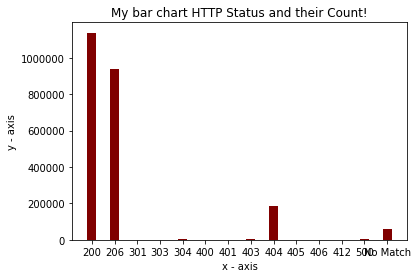

In [12]:
# x-coordinates of left sides of bars  
left = [item[0] for item in result] 

print(left)
# heights of bars 
height = [item[1] for item in result] 

print(height)


# labels for bars 
tick_label = left 
  
# plotting a bar chart 
plot.bar(left, height , color ='maroon', width = 0.4) 
  
# naming the x-axis 
plot.xlabel('x - axis') 
# naming the y-axis 
plot.ylabel('y - axis') 
# plot title 
plot.title('My bar chart HTTP Status and their Count!') 
  
# function to show the plot 
plot.show() 

In [13]:
#9. How many unique hosts are there in the entire log and their average request 

#NUmber of Unique IP addresses making requests and Their average requests

#NUmber of Unique IP addresses
a=rdd.map(lambda line: (line[0], 1)).groupByKey().map(lambda (x,y) : x).count()
print(a)

#Total number of requests by these Unique IP addresses
b=rdd.map(lambda line: (line[0], 1)).groupByKey().map(lambda (x,y) : len(y)).sum()
print(b)

#average requests made by these hosts
average=float(b/a)

print(average)



40836
2338006
57.0


In [ ]:
#10. Create a spark-submit application for the same and print the findings in the log


#Note the Jupyter Notebook is being submitted

#Note that Plot has been shown using matplotlib in Jupyter Notebook only